In [48]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data and create time features

In [49]:
project_1074 = pd.read_csv('../capstone_data/Azimuth/project_1074.csv')
project_1074.dropna(inplace=True)
project_1074.info()

project_1074['t'] = pd.to_datetime(project_1074['t'], format='%Y-%m-%d %H:%M:%S')
project_1074.sort_values('t',inplace=True)
project_1074 = project_1074.set_index('t')
project_1074['year'] = project_1074.index.year
project_1074['month'] = project_1074.index.month
project_1074['day'] = project_1074.index.day
project_1074['dayofweek'] = project_1074.index.dayofweek
project_1074['hour'] = project_1074.index.hour

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21518 entries, 0 to 21521
Data columns (total 9 columns):
project_id    21518 non-null object
t             21518 non-null object
relay         21518 non-null float64
load_v1rms    21518 non-null float64
load_v2rms    21518 non-null float64
load_v3rms    21518 non-null float64
load_i1rms    21518 non-null float64
load_i2rms    21518 non-null float64
laod_i3rms    21518 non-null float64
dtypes: float64(7), object(2)
memory usage: 1.6+ MB


## Reduce Relay signal to 0s and 1s

In [50]:
# Already the correct way round in the data
project_1074['relay_est'] = project_1074['relay'].apply(lambda x: 0 if x == 0.0 else 1)

In [51]:
project_1074['relay_est'].value_counts()

0    20242
1     1276
Name: relay_est, dtype: int64

## Identify records where time continuity is broken

In [52]:
# tagging periods where the proceeding datapoint is not 5 minutes
time = pd.Series(project_1074.index)
time2 = pd.Series(project_1074.index).shift(1)
ser = pd.Series(time - time2)
ser = ser.apply(lambda x: None if x!=pd.to_timedelta('0 days 00:05:00')else 1)
project_1074['t_diff']= pd.Series(ser).values

## Plots for examining data

In [53]:
def plot_all_data(df,columns):
    years = df['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = df[(df['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)

    fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, 5*len(y_m_combinations)))
    for ax, c in zip(axs,y_m_combinations):
        temp = df[(df['year'] == c[0]) & (df['month'] == c[1])]
        for col in columns:
            ax.plot(temp.index, temp[col]/df[col].max())
        ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [54]:
def plot_time_frame(df,start,end,columns):
    '''
    Plot the timeseries for a given period of time
    PARAMETERS
    ------------
    df : Pandas DataFrame with DatetimeIndex
    start: string in format 'YYYY-MM-DD HH:MM:SS'
    end: string in format 'YYYY-MM-DD HH:MM:SS'
    columns: list of column names
    RETURNS
    -------
    None: plots the graphs
    '''
    temp = df.loc[(df.index>=start)&(df.index<end)]
    years = temp['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = temp[(temp['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)
    
    if len(y_m_combinations) ==1:
        temp2 = temp[(temp['year'] == y_m_combinations[0][0]) & (temp['month'] == y_m_combinations[0][1])]
        plt.figure(figsize=(14,4))
        for col in columns:
            plt.plot(temp2.index, temp2[col]/df[col].max())
        plt.title('timeseries for {}, {}'.format(y_m_combinations[0][0],y_m_combinations[0][0]))
        
    else:
        fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, len(y_m_combinations)*4))
        for ax, c in zip(axs,y_m_combinations):
            temp2 = temp[(temp['year'] == c[0]) & (temp['month'] == c[1])]
            for col in columns:
                ax.plot(temp2.index, temp2[col]/df[col].max())
            ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [55]:
project_1074.index.min()

Timestamp('2017-05-26 10:05:00')

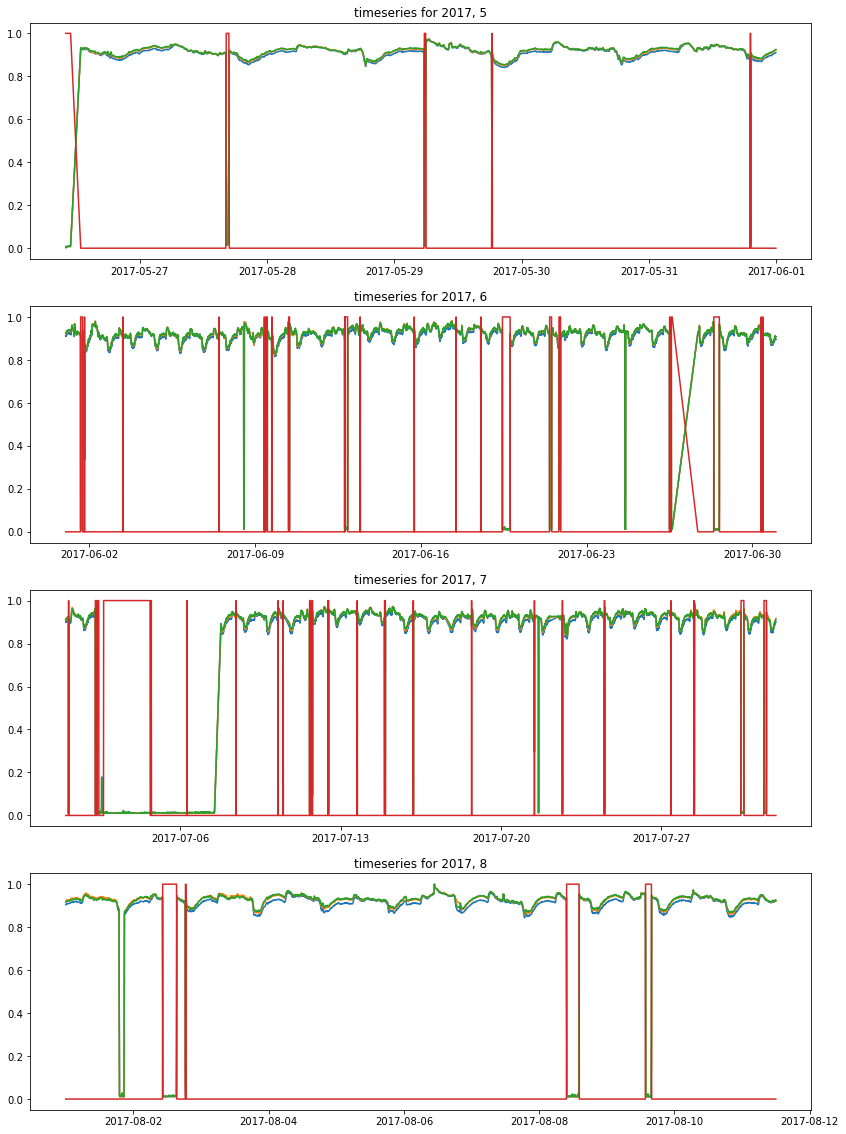

In [56]:
plot_all_data(project_1074, columns=['load_v1rms','load_v2rms','load_v3rms','relay_est'])

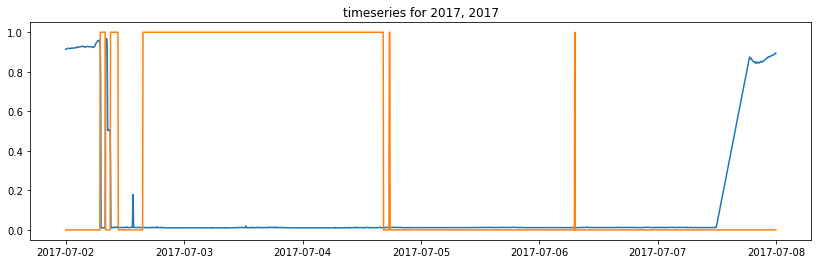

In [57]:
plot_time_frame(project_1074,'2017-07-02 00:00:00','2017-07-08 00:00:00',columns=['load_v1rms','relay_est'])

In [58]:
bad_data = [('2017-05-26 00:00:00','2017-05-27 00:00:00'),
           ('2017-06-26 13:00:00','2017-06-27 18:00:00'),
           ('2017-07-02 00:00:00','2017-07-08 00:00:00')]

## Function to label and remove bad data periods

In [59]:
def label_bad_data(df, dates):
    df['data_issue']=0
    for d in dates:
        df.loc[(df.index>=d[0])&(df.index<d[1]),'data_issue'] = 1
    return df

In [60]:
df = label_bad_data(project_1074, bad_data)
df.data_issue.value_counts()

0    19687
1     1831
Name: data_issue, dtype: int64

In [61]:
def remove_time_period(df,start, end):
    new_df = df.loc[~((df.index>=start)&(df.index<end))]
    return new_df

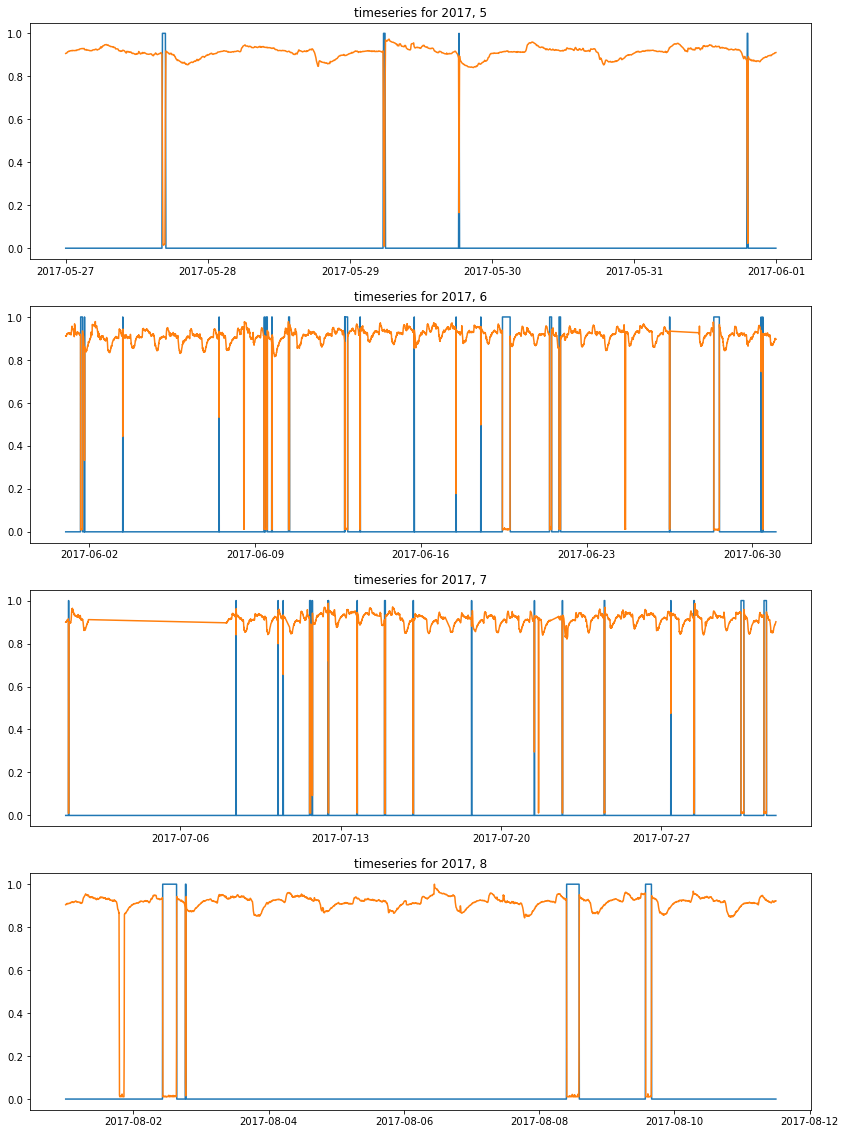

In [62]:
df2 = df[df['data_issue']!=1]
plot_all_data(df2, ['relay_est','load_v1rms'])

## Write data to csv

In [63]:
df2.to_csv('../capstone_data/Azimuth/clean/project_1074_clean.csv', index=True)